##INCERTIDUMBRE EN CLASIFICACIÓN:

El objetivo es principal es implementar una red neuronal bayesiana por dentro, utilizando el algoritmo de inferencia de Bayes By Backprop, y comparar su comportamiento con su correspondiente red determinista en un problema de clasificación clásico. También se estudiará el fenómeno conocido como Cold Posterior Effect, que es uno de los principales problemas de los BNNs a día de hoy.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##PREPROCESADO

Cargaremos las imágenes de CIFAR-10, y las cargaremos en los datasets que se usarán para el entrenamiento del modelo. No obstante, exluiremos todas las imágenes de una clase para exponer a los modelos a situaciones de incertidumbre.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifar10-pngs-in-folders


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root="/kaggle/input/cifar10-pngs-in-folders/cifar10/train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/cifar10-pngs-in-folders/cifar10/test", transform=transform)

#Obtener las clases
classes = train_dataset.classes
excluded_class_idx = len(classes) - 1  # Índice de la última clase, la cual excluiremos

#Función para filtrar el dataset
def filter_dataset(dataset, excluded_idx):
    filtered_indices = [i for i, (_, label) in enumerate(dataset.samples) if label != excluded_idx] #exluimos la clase
    return Subset(dataset, filtered_indices)

#Crear datasets filtrados
filtered_train_dataset = filter_dataset(train_dataset, excluded_class_idx)
filtered_test_dataset = filter_dataset(test_dataset, excluded_class_idx)

#Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
filtered_test_loader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

print("Clases originales:", classes)
print("Clase excluida:", classes[excluded_class_idx])

Clases originales: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Clase excluida: truck


In [ ]:
import sys
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

In [ ]:
#Mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

##BAYES BY BACKPROP

Para la implementación de las capas siguiendo las directrices de Bayes By Backprop, me apoyé de los artículos y los repositorios de Kumar Shridhar y sus compañeros en los siguientes trabajos:

-A comprehensive guide to bayesian convolutional neural network with variational inference

-Uncertainty estimations by softplus normalization in bayesian convolutional neural networks with variational inference}

Tendremos que definir por un lado la capa convolucional bayesiana y por el otro la capa densa bayesiana.

In [ ]:
#Calcula la divergencia de KL para el caso normal, que es el que impondremos.
def calculate_kl(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

In [ ]:
#Capa convolucional segun BBB
class BBBConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None):

        super(BBBConv2d, self).__init__()

        # Inicialización de parámetros de la capa convolucional
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Configuración de valores por defecto para los priors
        if priors is None:
            priors = {
                'prior_mu': 0,               # Media de la distribución previa
                'prior_sigma': 1,           # Desviación estándar de la distribución previa (era 0.1)
                'posterior_mu_initial': (0, 0.1),   # Inicialización de la media de la distribución posterior
                'posterior_rho_initial': (-3, 0.1), # Inicialización de rho (para calcular sigma)
            }

        # Almacenar los priors
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Definir los parámetros bayesianos de la capa convolucional
        self.W_mu = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.W_rho = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        # Si se usa sesgo, definir parámetros para el sesgo
        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = nn.Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        # Inicializar parámetros
        self.reset_parameters()

    def reset_parameters(self):
        """
        Inicializa los parámetros mu y rho con distribuciones normales.
        """
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        """
        Propagación hacia adelante usando el local reparametrization trick.
        En lugar de muestrear los pesos, se calcula directamente la media y la varianza de la activación.
        """
        # Transformar rho a sigma para los pesos
        #self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        self.W_sigma =  F.softplus(self.W_rho)
        if self.use_bias:
            #self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            self.bias_sigma = F.softplus(self.bias_rho)
            bias_var = self.bias_sigma ** 2
        else:
            #self.bias_sigma = None
            bias_sigma = None
            bias_var = None

        # Calcular la media de la activación (act_mu)
        act_mu = F.conv2d(input, self.W_mu, self.bias_mu, self.stride, self.padding, self.dilation, self.groups)
        # Calcular la varianza de la activación (act_var) usando la convolución de x^2
        act_var = 1e-16 + F.conv2d(input ** 2, self.W_sigma ** 2, bias_var, self.stride, self.padding, self.dilation, self.groups)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            # Muestreo a partir de la distribución normal definida por act_mu y act_std
            eps = torch.empty_like(act_mu).normal_(0, 1).to(self.device)
            #eps = torch.randn_like(act_mu, device=input.device)
            return act_mu + act_std * eps #Local reparametrization trick
        else:
            # En modo evaluación, se utiliza la media de la activación
            return act_mu

    def kl_loss(self):
        """
        Calcula la pérdida de divergencia KL entre la distribución posterior y la distribución previa.
        Para ello usamos la función definida anteriormente calculate_kl(prior_mu, prior_sigma, posterior_mu, posterior_sigma)
        que realiza este cálculo en el caso normal.
        """
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


In [ ]:
# Capa densa Bayes By Backprop
class BBBDenseLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super(BBBDenseLayer, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Valores por defecto
        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }

        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Inicialización de parámetros
        self.W_mu = nn.Parameter(torch.empty(out_features, in_features, device=self.device))
        self.W_rho = nn.Parameter(torch.empty(out_features, in_features, device=self.device))
        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        W_sigma = F.softplus(self.W_rho)

        # Muestreo
        if self.training or sample:
            eps = torch.randn_like(self.W_mu, device=self.device)
            weight = self.W_mu + W_sigma * eps #Local Reparametrization trick
        else:
            weight = self.W_mu

        return F.linear(input, weight)

    def kl_loss(self):
        W_sigma = F.softplus(self.W_rho)
        return calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, W_sigma)


In [ ]:
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()

        # Capas convolucionales bayesianas
        self.conv1 = BBBConv2d(3, 8, kernel_size=3, padding=1, priors=None)
        self.conv2 = BBBConv2d(8, 8, kernel_size=3, padding=1, priors=None)
        self.conv3 = BBBConv2d(8, 16, kernel_size=3, padding=1, priors=None)
        self.conv4 = BBBConv2d(16, 16, kernel_size=3, padding=1, priors=None)

        # Capas densas bayesianas
        self.fc1 = BBBDenseLayer(16 * 8 * 8, 100)
        self.fc2 = BBBDenseLayer(100, 100)
        self.fc3 = BBBDenseLayer(100, 10)  # Salida de 9 clases

        self.pool = nn.MaxPool2d(2, 2)
        self.num_classes=10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 8 * 8) #Aplana la salida de la capa convolucional para el bloque de decision

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def calculate_kl(self):
        """
        Calcula la pérdida KL total de la red.
        """
        kl = self.conv1.kl_loss() + self.conv2.kl_loss()
        kl += self.conv3.kl_loss() + self.conv4.kl_loss()
        kl += self.fc1.kl_loss() + self.fc2.kl_loss() + self.fc3.kl_loss()
        return kl

In [ ]:
model_BBB = BayesianCNN().to("cuda" if torch.cuda.is_available() else "cpu")

# Resumen del modelo
print(model_BBB)

BayesianCNN(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (fc1): BBBDenseLayer()
  (fc2): BBBDenseLayer()
  (fc3): BBBDenseLayer()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
def acc(outputs, targets):
 return np.mean(outputs.detach().cpu().numpy().argmax(axis=1) == targets.detach().cpu().numpy())

In [ ]:
#Definimos la ELBO
class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean') * self.train_size + beta * kl #Beta sera nuestro parametro de temperatura

In [ ]:
def logmeanexp(x, dim=None, keepdim=False):
    """Cálculo estable de: log(mean(exp(x))"""


    if dim is None:
        x, dim = x.view(-1), 0
    x_max, _ = torch.max(x, dim, keepdim=True)
    x = x_max + torch.log(torch.mean(torch.exp(x - x_max), dim, keepdim=True))
    return x if keepdim else x.squeeze(dim)

In [ ]:
def get_beta(batch_idx, m, beta_type, epoch, num_epochs):
    if type(beta_type) is float:
        #return beta_type
        return 0

    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Soenderby":
        if epoch is None or num_epochs is None:
            raise ValueError('Soenderby method requires both epoch and num_epochs to be passed.')
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = 0
    return beta

A continuación definiremos los métodos de entrenamiento y de validación de los modelos.

In [ ]:
from torch.optim import Adam
#criterion = ELBO(len(trainset)).to(device)
criterion = ELBO(len(train_loader)).to(device)
optimizer = Adam(model_BBB.parameters(), lr=2e-3)

In [ ]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, epoch=None, num_epochs=None):
    """
    Entrena la red bayesiana utilizando el enfoque de BBB con el local reparametrization trick.

    Parámetros:
      - net: modelo BNN 
      - optimizer: optimizador
      - criterion: función de pérdida
      - trainloader: DataLoader de entrenamiento
      - num_ens: número de muestras para el ensemble (cuántas veces se muestrea la salida del modelo)
      - beta_type, epoch, num_epochs: parámetros para la función que calcula beta (para ponderar la pérdida KL)

    Devuelve:
      - pérdida media del entrenamiento, precision media y pérdida KL media.
    """
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []

    for i, (inputs, labels) in enumerate(trainloader, 1):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs, labels
        # Creamos un tensor para almacenar las salidas del ensemble
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        #outputs = torch.zeros(batch_size, net.num_classes, inputs.shape[2], inputs.shape[3], num_ens)
        kl = 0.0

        # Realizamos múltiples muestreos (ensemble)
        for j in range(num_ens):
            net_out= net(inputs)  # calcula la salida de la red
            _kl = net.calculate_kl()
            kl += _kl
            # Aplicamos log_softmax sobre la salida para obtener logits normalizados
            outputs[:,:, j] = F.log_softmax(net_out, dim=1)

        # Promediamos la divergencia KL a lo largo del ensemble
        kl = kl / num_ens
        kl_list.append(kl)

        # Agregamos las salidas del ensemble usando la técnica de log-mean-exp
        log_outputs = logmeanexp(outputs, dim=2)

        # Calculamos el factor beta para ponderar el término KL en la función de pérdida
        #beta = get_beta(i - 1, len(trainloader), 0.1, epoch, num_epochs)
        #beta=0.1
        beta=0.001 #T=10^-3
        loss = criterion(log_outputs, labels, kl, beta)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        accs.append(acc(log_outputs, labels))
        torch.cuda.empty_cache()

    return (
    training_loss / len(trainloader),
    np.mean([acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in accs]),
    np.mean([kl.detach().cpu().numpy() if isinstance(kl, torch.Tensor) else kl for kl in kl_list])
)

In [ ]:
def validate_model(net, criterion, validloader, num_ens=1, epoch=None, num_epochs=None):
    """Calcula la precisión y la pérdida sobre el conjunto de validación"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs, labels
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        #outputs = torch.zeros(batch_size, net.num_classes, inputs.shape[2], inputs.shape[3], num_ens)
        kl = 0.0
        for j in range(num_ens):
            net_out = net(inputs)  
            _kl = net.calculate_kl()
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        #beta = get_beta(i - 1, len(validloader), 0.1, epoch, num_epochs)
        #beta=0.1
        beta=0.001
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs,labels))
        torch.cuda.empty_cache()

    return valid_loss/len(validloader),  np.mean([acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in accs])

In [ ]:
def run():
    train_ens = 5
    valid_ens = 5
    n_epochs = 100
    patience = 5
    patience_counter = 0

    net = model_BBB.to(device)
    path = 'model_bbb_256_512_T001.weights.h5'

    criterion = ELBO(len(train_loader)).to(device)
    optimizer = Adam(net.parameters(), lr=2e-3)
    valid_loss_max = np.inf

    # Para guardar el history
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_kl": [],
        "valid_loss": [],
        "valid_acc": []
    }

    for epoch in range(n_epochs):
        train_loss, train_acc, train_kl = train_model(
            net, optimizer, criterion, filtered_train_loader,
            num_ens=train_ens, epoch=epoch, num_epochs=n_epochs
        )
        valid_loss, valid_acc = validate_model(
            net, criterion, filtered_test_loader,
            num_ens=valid_ens, epoch=epoch, num_epochs=n_epochs
        )

        # Guardar en el history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_kl"].append(train_kl)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_max, valid_loss))
            torch.save(net.state_dict(), path)
            valid_loss_max = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Early stopping patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot de resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["valid_loss"], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["valid_acc"], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
torch.cuda.empty_cache()
run()

Epoch: 0 	Training Loss: 104920.0969 	Training Accuracy: 0.3728 	Test Loss: 216416.5429 	Test Accuracy: 0.3999 	train_kl_div: 10360755.0000
Validation loss decreased (inf --> 216416.542886).  Saving model ...
Epoch: 1 	Training Loss: 28348.6739 	Training Accuracy: 0.4175 	Test Loss: 85988.4564 	Test Accuracy: 0.4322 	train_kl_div: 2713166.5000
Validation loss decreased (216416.542886 --> 85988.456394).  Saving model ...
Epoch: 2 	Training Loss: 13405.3748 	Training Accuracy: 0.4266 	Test Loss: 44625.9256 	Test Accuracy: 0.4246 	train_kl_div: 1219408.6250
Validation loss decreased (85988.456394 --> 44625.925643).  Saving model ...
Epoch: 3 	Training Loss: 7879.2690 	Training Accuracy: 0.4232 	Test Loss: 26573.7346 	Test Accuracy: 0.4271 	train_kl_div: 665727.9375
Validation loss decreased (44625.925643 --> 26573.734555).  Saving model ...
Epoch: 4 	Training Loss: 5270.3103 	Training Accuracy: 0.4285 	Test Loss: 17308.1179 	Test Accuracy: 0.4317 	train_kl_div: 404915.8125
Validation loss

In [ ]:
class DeterministicCNN(nn.Module):
    def __init__(self):
        super(DeterministicCNN, self).__init__()

        # Capas convolucionales deterministas
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        # Capas densas deterministas
        self.fc1 = nn.Linear(16 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)  # Salida de 10 clases

        self.pool = nn.MaxPool2d(2, 2)
        self.num_classes = 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
def train_deterministic_model(net, optimizer, criterion, trainloader):
    """
    Parámetros:
      - net: modelo determinista
      - optimizer: optimizador
      - criterion: función de pérdida, en este caso, entropia cruzada
      - trainloader: DataLoader de entrenamiento

    Devuelve:
      - pérdida media del entrenamiento y precision media.
    """
    net.train()
    training_loss = 0.0
    accs = []

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        accs.append(acc(outputs, labels))  

        torch.cuda.empty_cache()

    return (
        training_loss / len(trainloader),
        np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])
    )



In [ ]:
def validate_deterministic_model(net, criterion, validloader):
    """
    Parámetros:
      - net: modelo determinista
      - criterion: función de pérdida 
      - validloader: DataLoader de validación

    Devuelve:
      - pérdida media en conjunto validación y precision media.
    """
    net.eval()
    valid_loss = 0.0
    accs = []

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)  # forward determinista
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            accs.append(acc(outputs, labels))

    return (
        valid_loss / len(validloader),
        np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])
    )


In [ ]:

def run_deterministic():
    n_epochs = 20
    patience = 5
    patience_counter = 0

    net = DeterministicCNN().to(device)
    path = 'model_deterministic.weights.h5'

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
    valid_loss_max = np.inf

    # Inicializar history
    history = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    for epoch in range(n_epochs):
        train_loss, train_acc = train_deterministic_model(net, optimizer, criterion, filtered_train_loader)
        valid_loss, valid_acc = validate_deterministic_model(net, criterion, filtered_test_loader)

        # Guardar en history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_max, valid_loss))
            torch.save(net.state_dict(), path)
            valid_loss_max = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Early stopping patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["valid_loss"], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["valid_acc"], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
run_deterministic()

##PRUEBAS

Estudiaremos el comportamiento de los modelos ante la clase conocida y ante la clase desconocida.

In [ ]:
model_nobay = DeterministicCNN().to(device)

In [ ]:
model_nobay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_deterministic.weights.h5'))

model_nobay.eval()

<ipython-input-26-4cf375eb89f0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_nobay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_deterministic.weights.h5

DeterministicCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
model_bay=BayesianCNN().to(device)
model_bay.load_state_dict(torch.load('/kaggle/input/pesoskl0001/model_bbb_256_512_T001.weights.h5'))

model_bay.train()

<ipython-input-27-084041cc942e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_bay.load_state_dict(torch.load('/kaggle/input/pesoskl0001/model_bbb_256_512_T001.weigh

BayesianCNN(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (fc1): BBBDenseLayer()
  (fc2): BBBDenseLayer()
  (fc3): BBBDenseLayer()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

A continuación, seleccionaremos dos imágenes aleatorias, una de una clase cualquiera vista durante el entrenamiento, y otra de la clase desconocida.

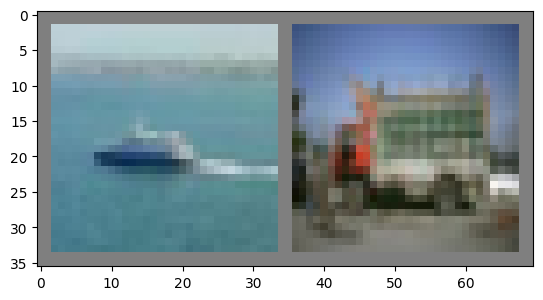

Conocida: ship | Desconocida: truck


In [ ]:
import random


def get_random_sample(dataset, label_to_select):
    indices = [i for i, (_, label) in enumerate(dataset) if label == label_to_select]
    idx = random.choice(indices)
    return dataset[idx][0].unsqueeze(0), label_to_select  # imagen y su clase real

# Clase desconocida (excluida del entrenamiento)
x_unk, y_unk = get_random_sample(test_dataset, excluded_class_idx)
# Clase conocida
x_known, y_known = get_random_sample(filtered_test_dataset, random.randint(0, excluded_class_idx - 1))

x_unk, x_known = x_unk.to(device), x_known.to(device)

#Visualización de imágenes aleatorias seleccionadas
imshow(torchvision.utils.make_grid(torch.cat([x_known.cpu(), x_unk.cpu()])))
print("Conocida:", classes[y_known], "| Desconocida:", classes[y_unk])


Para esas imágenes, calculamos la distribución de predicción de cada modelo, viendo las probabilidades que otorga a cada clase:

In [ ]:
#Obtiene las probabilidades de prediccion por clase del modelo determinista para una entrada
def predict_deterministic(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    return probs

probs_known_det = predict_deterministic(model_nobay, x_known)
probs_unk_det = predict_deterministic(model_nobay, x_unk)


In [ ]:
#Obtiene las probabilidades de prediccion por clase del modelo bayesiano para una entrada
def predict_bayesian(model, x, num_samples=50):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for _ in range(num_samples):
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            all_probs.append(probs)
    return np.array(all_probs)  # shape: (num_samples, num_classes)

probs_known_bayes = predict_bayesian(model_bay, x_known)
probs_unk_bayes = predict_bayesian(model_bay, x_unk)

In [ ]:
labels = train_dataset.classes

Representamos dichas probabilidades de pertenecer a las distintas clases:

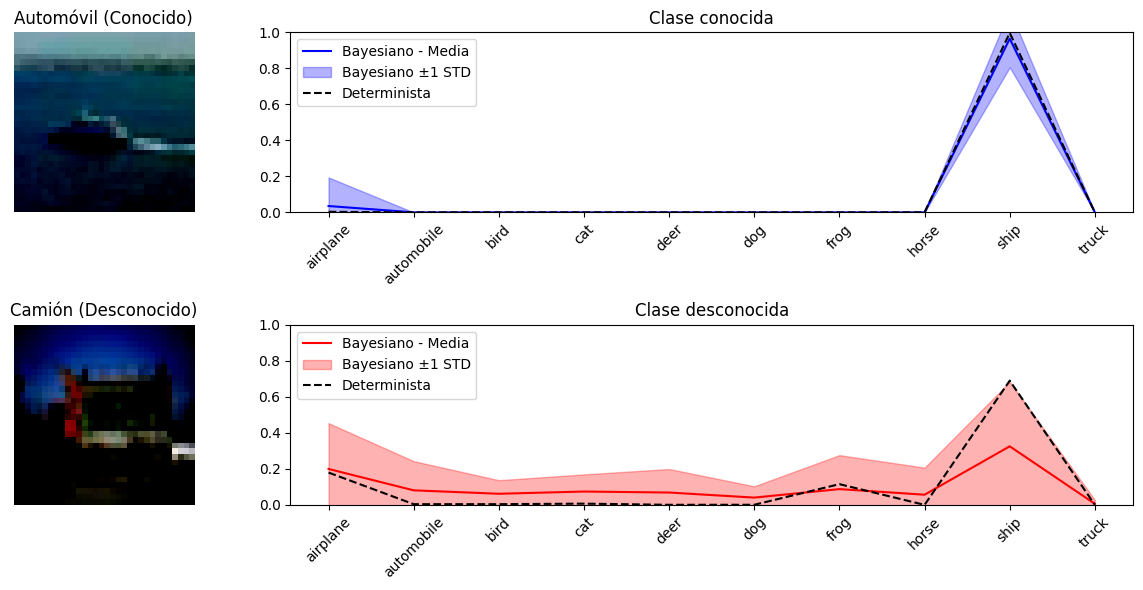

In [ ]:
import torchvision.transforms as T

def show_image(ax, tensor_image, title=""):
    img = tensor_image.squeeze().cpu()
    if img.shape[0] == 3:  # RGB
        img = img.permute(1, 2, 0)
    ax.imshow(img.numpy())
    ax.axis("off")
    ax.set_title(title)

def plot_comparison(ax, bayes_samples, det_probs, title, color, labels):
    bayes_samples = np.array(bayes_samples)
    mean_probs = bayes_samples.mean(axis=0)
    std_probs = bayes_samples.std(axis=0)

    # Bayesiano
    ax.plot(mean_probs, color=color, label="Bayesiano - Media")
    ax.fill_between(range(len(mean_probs)),
                    mean_probs - std_probs,
                    mean_probs + std_probs,
                    color=color, alpha=0.3, label="Bayesiano ±1 STD")

    # Determinista
    ax.plot(det_probs, color="black", linestyle="--", label="Determinista")

    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, 1)
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 3]})


show_image(axs[0, 0], x_known, "Barco (Conocido)")
plot_comparison(axs[0, 1], probs_known_bayes, probs_known_det, "Clase conocida", "blue", labels)


show_image(axs[1, 0], x_unk, "Camión (Desconocido)")
plot_comparison(axs[1, 1], probs_unk_bayes, probs_unk_det, "Clase desconocida", "red", labels)

plt.tight_layout()
plt.savefig("clases.png")
plt.show()


Ante la clase desconocida, el modelo determinista muestra una falsa confianza de que el camión es un barco, mientras que el modelo bayesiano muestra mucha más desconfianza y duda de si es un barco o un avisón. Ante la clase conocida, ambos de comportan de manera similar.

In [ ]:
#Para visualizar la dispersión de las predicciones del modelo bayesiano en la clase conocida y desconocida.
def plot_bayesian_scatter(ax, bayes_samples, labels, title, color):
    bayes_samples = np.array(bayes_samples)
    pred_classes = np.argmax(bayes_samples, axis=1)

    # Eje X: clase predicha, Eje Y: Un índice para cada muestra
    x = pred_classes
    y = np.arange(len(pred_classes)) + np.random.uniform(-0.3, 0.3, size=len(pred_classes))

    ax.scatter(x, y, c=color, alpha=0.6)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel("Clases predichas")
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)


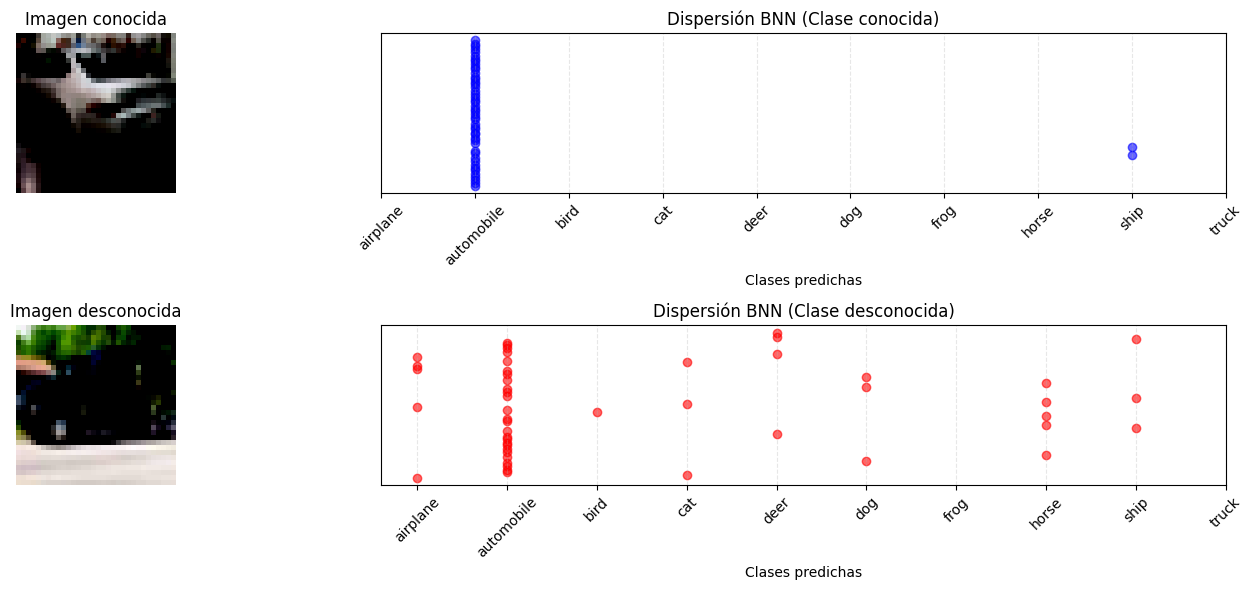

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))


show_image(axs[0, 0], x_known, "Imagen conocida")
plot_bayesian_scatter(axs[0, 1], probs_known_bayes, labels, "Dispersión BNN (Clase conocida)", "blue")


show_image(axs[1, 0], x_unk, "Imagen desconocida")
plot_bayesian_scatter(axs[1, 1], probs_unk_bayes, labels, "Dispersión BNN (Clase desconocida)", "red")

plt.tight_layout()
plt.savefig("disp.png")
plt.show()


Podemos observar que el modelo bayesiano es capaz de demostrar su desconfianza al no haber sido entrenado con dicha clase.

##COLD POSTERIOR EFFECT:

A continuación mostraremos el efecto de cambiar el valor del parámetro de Temperatura en la pérdida, y por tanto en el aprendizaje del modelo.

In [ ]:
temperatures = [1.0, 0.5, 0.1, 0.01, 0.001,0.0001]

In [ ]:
def validate_model(net, criterion, validloader, num_ens=1, epoch=None, num_epochs=None, beta=0.0001):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()  # Esto es intencional si estás usando MC dropout o redes bayesianas con sampling
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out = net(inputs)  # se espera que devuelva solo logits
            _kl = net.calculate_kl()
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs, labels))
        torch.cuda.empty_cache()

    return valid_loss / len(validloader), np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])


Beta (T): 1.0000 | Loss: 843590.0448 | Accuracy: 0.6620
Beta (T): 0.5000 | Loss: 422189.4167 | Accuracy: 0.6666
Beta (T): 0.1000 | Loss: 85096.5271 | Accuracy: 0.6565
Beta (T): 0.0100 | Loss: 9232.9394 | Accuracy: 0.6581
Beta (T): 0.0010 | Loss: 1648.6417 | Accuracy: 0.6559
Beta (T): 0.0001 | Loss: 896.0422 | Accuracy: 0.6591


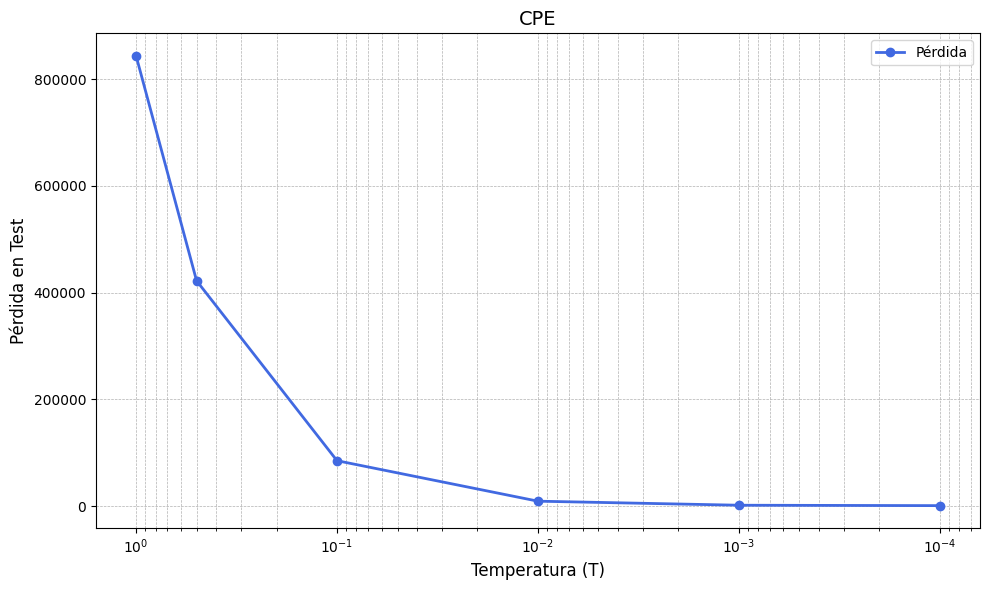

In [ ]:
import matplotlib.pyplot as plt

temperatures = [1.0, 0.5, 0.1, 0.01, 0.001,0.0001]
losses = []
accuracies = []


# Evaluar el modelo para cada temperatura
for beta in temperatures:
    val_loss, val_acc = validate_model(model_bay, criterion, filtered_test_loader, num_ens=5, beta=beta)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f"Beta (T): {beta:.4f} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

# Representar
plt.figure(figsize=(10, 6))
plt.plot(temperatures, losses, marker='o', linestyle='-', linewidth=2, color='royalblue', label='Pérdida')
plt.xscale('log')
plt.gca().invert_xaxis()  # Invertir eje X visualmente si quieres que T decrezca de izquierda a derecha
plt.xlabel('Temperatura (T)', fontsize=12)
plt.ylabel('Pérdida en Test', fontsize=12)
plt.title('CPE', fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("perdida_vs_temperatura.png")
plt.show()


El modelo se intentó entrenar para temperaturas lo más cercanas a 1 posible, para ser lo más fiel posible a la teoría bayesiana del proyecto. Sin embargo esto fue imposible, pues el modelo caía constantemente en underfitting. Finalmente nos quedamos en torno a T=10^-3 para nuestros experimentos.